In [ ]:
import logging
import os, json
from glob import glob

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2 as cv
import numpy as np
import tensorflow as tf
import shapely.wkt as wkt
import shapely.geometry as geometry
from matplotlib import pyplot as plt
from colormap.colors import Color, hex2rgb
from sklearn.utils.class_weight import compute_class_weight

ModuleNotFoundError: ignored

In [ ]:
image_dir = 'data/processed/images/'
mask_dir = 'data/processed/masks/'

input_shape = (256, 256, 3)
output_shape_orig = (256, 256, 3)
output_shape_new = (65536, 3)

# input_shape = (128, 128, 3)
# output_shape_orig = (128, 128, 3)
# output_shape_new = (16384, 3)

segmentation_weights = 'weights/segmentation.h5'
classification_weights = 'weights/classification.h5'

background_color = 0
leaf_color = 255
spot_color = 128

disease_dict = {
                'algal leaf': 0,
                'brown blight': 1,
                'greyblight_new': 2,
                'red leaf spot': 3,
                'white spot': 4
                }

disease_color_dict = {v : k for k, v in disease_dict.items()}

In [ ]:
def image_denoiser(
                    image_path,
                    apply_denoising = False
                    ):
    img = cv.imread(image_path)
    if apply_denoising:
        img = cv.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    return img

def preprocess_input(image_path):
    img = image_denoiser(image_path)
    original_img = img

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    img_norm = img / 255.0
    return img_norm, original_img

def preprocess_output(mask_path):
    mask = cv.imread(mask_path)
    mask = cv.resize(mask, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

    mask[mask == background_color] = 0
    mask[mask == leaf_color] = 1
    mask[mask == spot_color] = 2
    mask_new = mask.reshape(mask.shape[0] * mask.shape[1],)
    mask_new = tf.one_hot(mask_new, 3).numpy()
    return mask_new

In [ ]:
all_masks = glob(mask_dir + '*/*.png')
for mask_path in all_masks:
    mask = cv.imread(mask_path)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    unique_colors = np.unique(mask).tolist()
    assert list(set(unique_colors) - set([ 0,128,255])) == [], 'Invalid mask color found in {}'.format(mask_path)
print('All masks are valid')

All masks are valid


In [ ]:
def prepare_dataset():
    images = glob(image_dir+"*/*.jpg")

    X = []
    Y1 = []
    Y2 = []

    for image_path in images:
        image_path = image_path.replace("\\", "/")
        mask_path = image_path.replace(image_dir, mask_dir).replace(".jpg", ".png")
        if os.path.exists(mask_path) and os.path.exists(image_path):
            disease_name = image_path.split("/")[-2]
            img = preprocess_input(image_path)[0]
            mask = preprocess_output(mask_path)
            X.append(img)
            Y1.append(mask)
            Y2.append(disease_dict[disease_name])

    X = np.asarray(X)
    Y1 = np.asarray(Y1)
    Y2 = np.asarray(Y2)

    rand_idxs = np.random.permutation(len(X))
    X = X[rand_idxs]
    Y1 = Y1[rand_idxs]
    Y2 = Y2[rand_idxs]

    return X, Y1, Y2

In [ ]:
X, Y1, Y2 = prepare_dataset()

In [ ]:
print('input shape                     : ', X.shape)
print('output shape (Segmentation)     : ', Y1.shape)
print('output shape (Classififcation)  : ', Y2.shape)

input shape                     :  (642, 256, 256, 3)
output shape (Segmentation)     :  (642, 65536, 3)
output shape (Classififcation)  :  (642,)


In [ ]:
# raw_output = Y.argmax(axis=-1).reshape(-1,)

# class_weights = compute_class_weight(
#                                 'balanced',
#                                  classes = np.unique(raw_output),
#                                  y = raw_output)

# '''

# Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

# '''
# class_weights = {i : class_weights[i] for i in range(len(set(raw_output)))}
# class_weights

class_weights = {0: 0.45502023552571574, 1: 1.3932690999265989, 2: 11.826047605800213}

In [ ]:
binary_output = Y1.argmax(axis=-1)
sample_weight = np.zeros((Y1.shape[0], Y1.shape[1]))
sample_weight[np.where(binary_output == 0)] = class_weights[0]
sample_weight[np.where(binary_output == 1)] = class_weights[1]
sample_weight[np.where(binary_output == 2)] = class_weights[2]

In [ ]:
def downsample_block(filters, input):
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu',
              kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Dropout(0.2)(conv)
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu',
              kernel_initializer='he_normal', padding='same')(conv)
    pool = tf.keras.layers.MaxPool2D((2, 2))(conv)
    return pool, conv

def upsample_block(filters, conv, conv_p):
    up = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2, 2))(conv), conv_p], axis=-1)
    conv_n = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu',
              kernel_initializer='he_normal', padding='same')(up)
    conv_n = tf.keras.layers.Dropout(0.2)(conv_n)
    conv_n = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu',
              kernel_initializer='he_normal', padding='same')(conv_n)
    return conv_n

def unet_model():
    input = tf.keras.layers.Input(shape=input_shape, name='input')

    if input_shape[0] == 128:
        c1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(input)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
        p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)

        c2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p1)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        c2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c2)
        p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)

        c3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p2)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c3)
        p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

        c4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p3)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p4)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c5)

        # Expansive path:
        u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u6)
        c6 = tf.keras.layers.Dropout(0.2)(c6)
        c6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c6)

        u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u7)
        c7 = tf.keras.layers.Dropout(0.2)(c7)
        c7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c7)

        u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u8)
        c8 = tf.keras.layers.Dropout(0.1)(c8)
        c8 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c8)

        u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
        c9 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u9)
        c9 = tf.keras.layers.Dropout(0.1)(c9)
        c9 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c9)
        logits = tf.keras.layers.Conv2D(3, (1, 1))(c9)

        logits = tf.keras.layers.Reshape(
                                        output_shape_new,
                                        input_shape = output_shape_orig
                                        )(logits)
        output = tf.keras.layers.Softmax()(logits)

    elif input_shape[0] == 256:
        pool1, conv1 = downsample_block(32, input)
        pool2, conv2 = downsample_block(64, pool1)
        pool3, conv3 = downsample_block(128, pool2)

        conv4 = downsample_block(128, pool3)[1]

        conv5 = upsample_block(64, conv4, conv3)
        conv6 = upsample_block(64, conv5, conv2)
        conv7 = upsample_block(32, conv6, conv1)
        conv8 = tf.keras.layers.Conv2D(3, (1, 1))(conv7)

        logits = tf.keras.layers.Reshape(
                    output_shape_new,
                    input_shape = output_shape_orig
                    )(conv8)
        output = tf.keras.layers.Softmax()(logits)

    elif input_shape[0] == 1024:
        pool1, conv1 = downsample_block(32, input)
        pool2, conv2 = downsample_block(32, pool1)
        pool3, conv3 = downsample_block(64, pool2)
        pool4, conv4 = downsample_block(64, pool3)
        pool5, conv5 = downsample_block(128, pool4)

        conv6 = downsample_block(128, pool5)[1]

        conv7 = upsample_block(128, conv6, conv5)
        conv8 = upsample_block(64, conv7, conv4)
        conv9 = upsample_block(64, conv8, conv3)
        conv10 = upsample_block(32, conv9, conv2)
        conv11 = upsample_block(32, conv10, conv1)
        conv12 = tf.keras.layers.Conv2D(3, (1, 1))(conv11)

        logits = tf.keras.layers.Reshape(
                    output_shape_new,
                    input_shape = output_shape_orig
                    )(conv12)

        output = tf.keras.layers.Softmax()(logits)

    else:
        assert False, 'input_shape[0] must be 256 or 1024'

    model = tf.keras.models.Model(
                                inputs=input,
                                outputs=output,
                                name='disease_segmentation'
                                )
    model.summary()

    return model

def train_segmentation(model):
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='loss',
                                                    patience=25,
                                                    restore_best_weights=True
                                                    )

    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #                                                             0.00001,
    #                                                             decay_steps=100000,
    #                                                             decay_rate=0.96,
    #                                                             staircase=True
    #                                                             )

    model.compile(
                loss='categorical_crossentropy',
                # optimizer=tf.keras.optimizers.Adam(lr_schedule),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ],
                sample_weight_mode="temporal"
                )
    model.fit(
            X,
            Y1,
            epochs=100,
            batch_size=4,
            callbacks=[early_stopping],
            sample_weight=sample_weight
            )

    model.save(segmentation_weights)
    return model


def encoder_model():
    input = tf.keras.layers.Input(shape=input_shape, name='input')

    xception_model = tf.keras.applications.Xception(
                                                    include_top=False,
                                                    weights='imagenet',
                                                    input_shape=input_shape
                                                    )
    xception_model.trainable = False
    xception_output = xception_model(input)

    x = tf.keras.layers.GlobalAveragePooling2D()(xception_output)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(5, activation='softmax')(x)


    model = tf.keras.models.Model(
                                inputs=input,
                                outputs=output,
                                name='disease_classification'
                                )
    model.summary()

    return model

def train_classification(model):
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='loss',
                                                    patience=25,
                                                    restore_best_weights=True
                                                    )

    model.compile(
                loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ]
                )
    model.fit(
            X,
            tf.keras.utils.to_categorical(Y2, num_classes=5),
            epochs=100,
            batch_size=4,
            callbacks=[early_stopping]
            )

    model.save(classification_weights)
    return model

In [ ]:
unet = unet_model()
train_segmentation(unet)

Model: "disease_segmentation"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                              

In [ ]:
cls = encoder_model()
train_classification(cls)

Model: "disease_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                            

In [ ]:
segmentation_model = tf.keras.models.load_model(segmentation_weights)
classification_model = tf.keras.models.load_model(classification_weights)

1/1 [==============================] - 0s 24ms/step


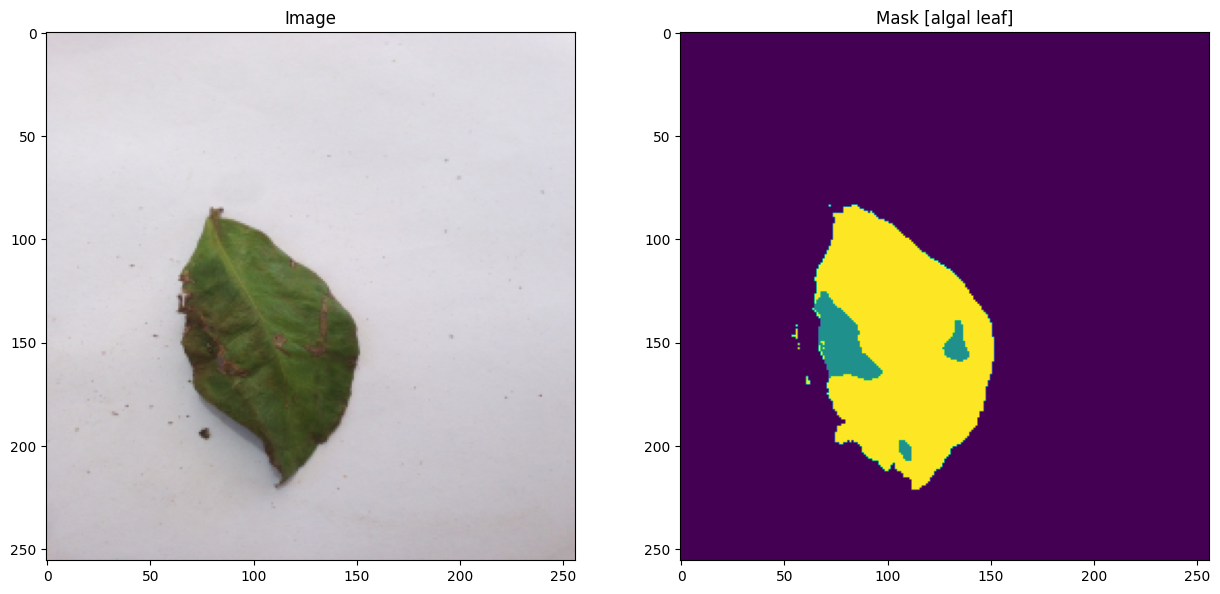

In [ ]:
idx = np.random.randint(0, X.shape[0])
test_image = X[idx]

test_mask = Y1[idx].argmax(axis=-1)
test_mask = test_mask.reshape(output_shape_orig[0], output_shape_orig[1], 1)
test_mask[test_mask == 0] = background_color
test_mask[test_mask == 1] = leaf_color
test_mask[test_mask == 2] = spot_color

Prediction = segmentation_model.predict(np.expand_dims(test_image, axis=0))
class_label = classification_model.predict(np.expand_dims(test_image, axis=0)).argmax(axis=-1)[0]
Prediction = Prediction.squeeze().argmax(axis=-1)
Prediction = Prediction.reshape(output_shape_orig[0], output_shape_orig[1], 1)
Prediction[Prediction == 0] = background_color
Prediction[Prediction == 1] = leaf_color
Prediction[Prediction == 2] = spot_color

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(Prediction)
plt.title('Mask [{}]'.format(disease_color_dict[class_label]))
plt.show()

# Inference

In [ ]:
segmentation_model = tf.keras.models.load_model(segmentation_weights)
classification_model = tf.keras.models.load_model(classification_weights)

In [ ]:
def preprocess_input(image_path):
    img = cv.imread(image_path)
    original_img = img

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    # img_norm = (img - 127.5) / 127.5
    img_norm = img / 255.0
    return img_norm, original_img

def inference_tea_leaves(image_path):
    image_path = image_path.replace("\\", "/")
    img, original_img = preprocess_input(image_path)
    Prediction = segmentation_model.predict(np.expand_dims(img, axis=0), verbose=0)
    class_label = classification_model.predict(np.expand_dims(img, axis=0), verbose=0).argmax(axis=-1)[0]
    real_label = image_path.split("/")[-2]
    Prediction = Prediction.squeeze().argmax(axis=-1)
    Prediction = Prediction.reshape(output_shape_orig[0], output_shape_orig[1], 1)
    Prediction[Prediction == 0] = background_color
    Prediction[Prediction == 1] = leaf_color
    Prediction[Prediction == 2] = spot_color

    width_orig, height_orig = original_img.shape[1], original_img.shape[0]
    Prediction = cv.resize(Prediction, (width_orig, height_orig), interpolation = cv.INTER_NEAREST)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Image [{}]'.format(real_label))
    plt.subplot(1, 2, 2)
    plt.imshow(Prediction)
    plt.title('Mask [{}]'.format(disease_color_dict[class_label]))
    plt.show()

data/processed/images\white spot\UNADJUSTEDNONRAW_thumb_b9.jpg


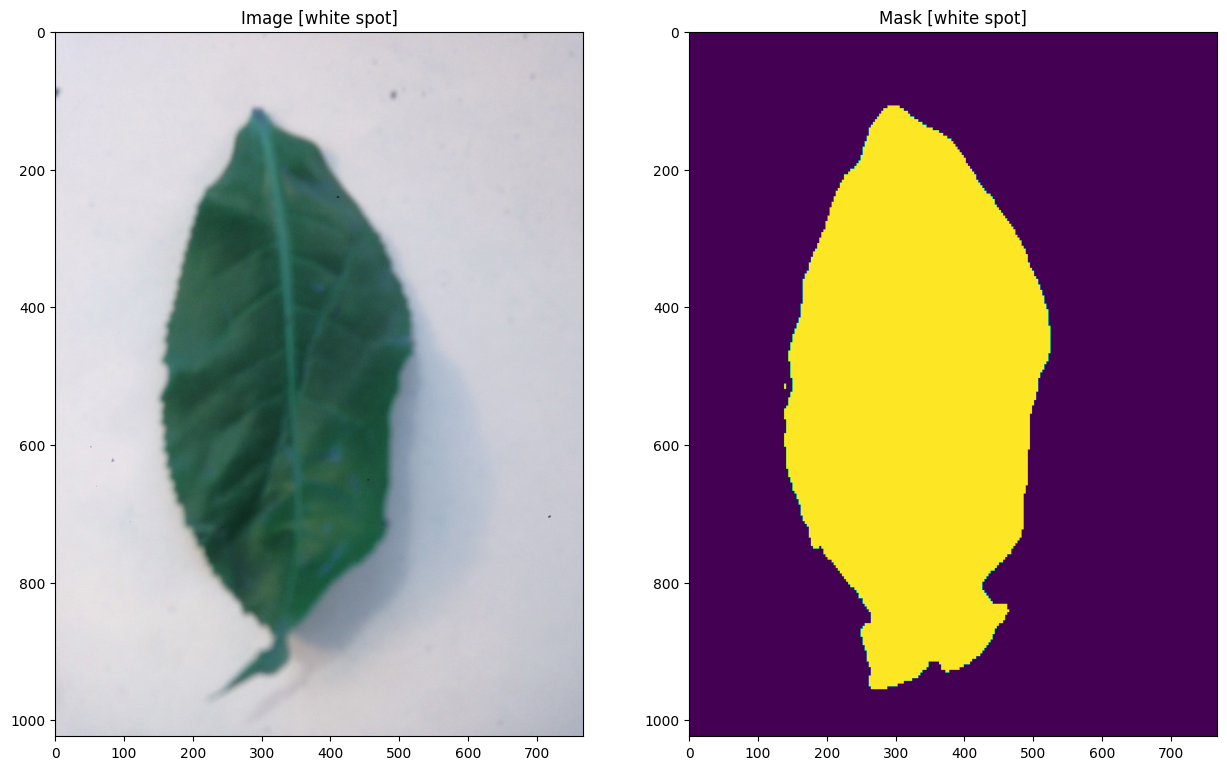

In [ ]:
all_images = glob('data/processed/images/*/*.jpg')

rand_idx = np.random.randint(0, len(all_images))
image_path = all_images[rand_idx]
print(image_path)
inference_tea_leaves(image_path)